## 부스팅(Boosting)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


- 데이터 전처리

In [3]:
# 중복 컬럼 배제 및 결측치 처리
df = df[['survived','pclass','sex','age','sibsp','parch','fare','embarked','who','deck']]
df.age.fillna(df[df.who.isin(['man', 'woman'])].age.mean().round(1), inplace=True)
df.embarked.fillna('S', inplace=True)
df.drop(columns=['deck','who'], inplace=True)
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [4]:
# 레이블 인코딩
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.sex = le.fit_transform(df.sex)
df.embarked = le.fit_transform(df.embarked)
df.tail(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked
888,0,3,0,32.8,1,2,23.45,2
889,1,1,1,26.0,0,0,30.00,0
890,0,3,1,32.0,0,0,7.75,1


In [5]:
X = df.iloc[:, 1:].values
y = df.survived.values

In [6]:
# 표준화
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_std, y, stratify=y, test_size=0.2, random_state=2023
)

### 1. XGBoost(eXtra Gradient Boost)
- 설치: conda activate base; pip install xgboost

In [8]:
import xgboost
xgboost.__version__

'2.0.0'

In [9]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [10]:
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
xgb.score(X_test, y_test)

0.7932960893854749

- 시각화

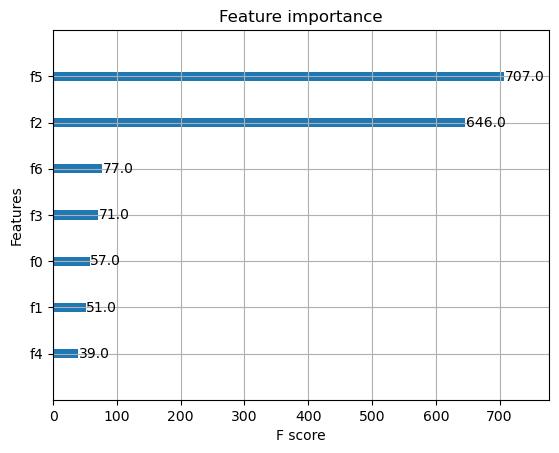

In [11]:
from xgboost import plot_importance as xgb_pi
import matplotlib.pyplot as plt

xgb_pi(xgb)
plt.show()

- GridSearchCV

In [12]:
from sklearn.model_selection import GridSearchCV
params = {'max_depth': [3, 6, 9]}
grid_xgb = GridSearchCV(xgb, params, scoring='accuracy', cv=5)
grid_xgb.fit(X_train, y_train)
grid_xgb.best_params_

{'max_depth': 3}

In [13]:
params = {'max_depth': [2, 3, 4, 5]}
grid_xgb = GridSearchCV(xgb, params, scoring='accuracy', cv=5)
grid_xgb.fit(X_train, y_train)
grid_xgb.best_params_

{'max_depth': 2}

In [14]:
grid_xgb.best_estimator_.score(X_test, y_test)

0.8100558659217877

### 2. Light GBM
- 설치: conda activate base; pip install lightgbm

In [15]:
import lightgbm
lightgbm.__version__

'4.1.0'

In [16]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(verbose=-1)
lgb.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbose': -1}

In [17]:
lgb.fit(X_train, y_train)

LGBMClassifier(verbose=-1)

In [18]:
pred_lgb = lgb.predict(X_test)
lgb.score(X_test, y_test)

0.7988826815642458

In [19]:
from lightgbm import plot_importance

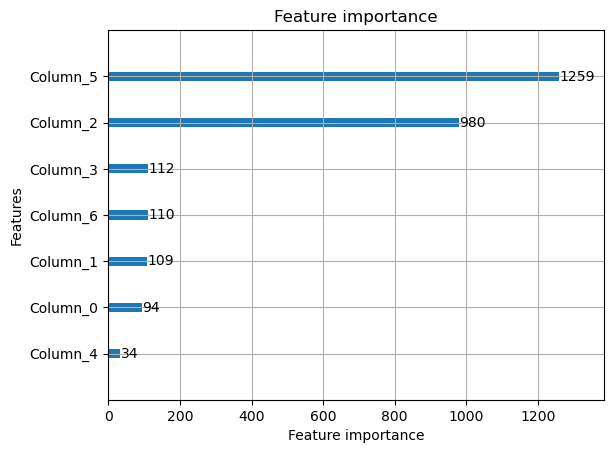

In [20]:
plot_importance(lgb);

- GridSearchCV

In [21]:
params = {'max_depth': [3, 6, 9]}
grid_lgb = GridSearchCV(lgb, params, scoring='accuracy', cv=5)
grid_lgb.fit(X_train, y_train)
grid_lgb.best_params_

{'max_depth': 3}

In [22]:
params = {'max_depth': [2, 3, 4, 5]}
grid_lgb = GridSearchCV(lgb, params, scoring='accuracy', cv=5)
grid_lgb.fit(X_train, y_train)
grid_lgb.best_params_

{'max_depth': 2}

In [23]:
grid_lgb.best_estimator_.score(X_test, y_test)

0.8156424581005587

#### 3. 두 모델 비교

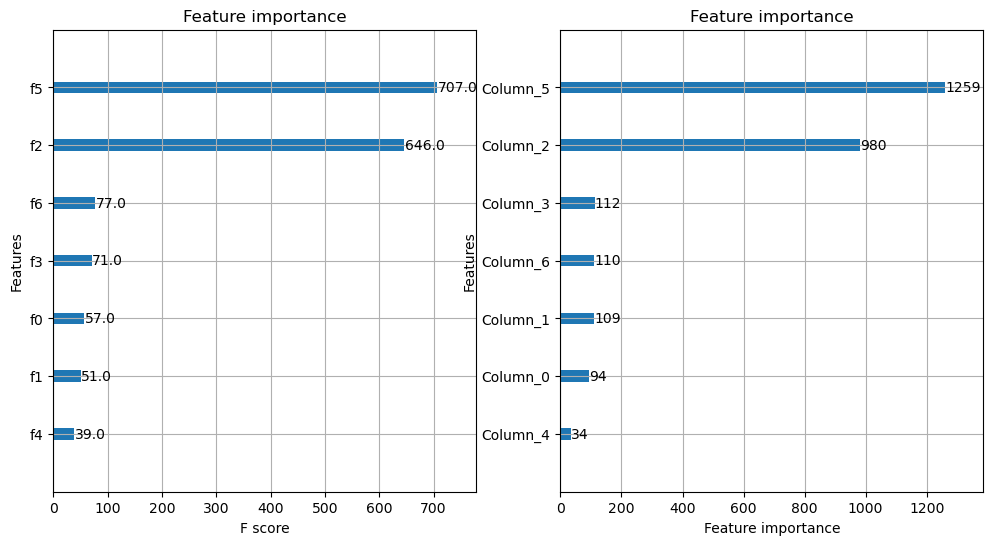

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
xgb_pi(xgb, ax=ax[0])
plot_importance(lgb, ax=ax[1])
plt.show()

In [25]:
rf = pd.DataFrame({'y 실제값': y_test, 'XGBoost': pred_xgb, 'LightGBM': pred_lgb})
rf.head()

,y 실제값,XGBoost,LightGBM
0,0,0,0
1,1,1,1
2,0,0,0
3,0,0,0
4,0,0,0
